Trying to update the Webscraping Indeed Notebook to Python 3

In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
# API Calls
import requests
# Parse HTML
import bs4
# Handle Dataframes (excel data)
import pandas as pd
# Plotting library
import matplotlib.pyplot as plt

## Fetching and Cleaning Indeed Search Data

In [211]:
from indeed_scraper import search_indeed, clean_data, save_data, posting_scraper
from utils import save_data

In [319]:
# Fetch Page Information for Indeed Search
# TODO: Add url encoding so you don't have to do it manually here.
query = "software+python"
cities = ["New+York%2C+NY", "Greenwich%2C+CT"]
max_results_per_city = 100
null_value = "NA"

df = search_indeed(query, cities, max_results_per_city, null_value)
df = clean_data(df)
filename = save_data(df, query, path='./indeed_searches/')
print(filename)

./indeed_searches/software+python-2018_11_27-022431


## Getting Data Per Posting Page (WIP)

In [320]:
# Getting one posting worth of data
# url = data.loc[:, 'url'].values[88]
# print(url)
# html = requests.get(url).text
# soups = bs4.BeautifulSoup(html, "html.parser")
# # Print out job description as one srting
# main_content = soups.find('div', {'class': "jobsearch-JobComponent icl-u-xs-mt--sm jobsearch-JobComponent-bottomDivider"})
# job_description = soups.find('div', {'class': "jobsearch-JobComponent-description icl-u-xs-mt--md"})
# ' '.join([x.get_text(strip=True) for x in job_description.find_all('li')])

In [321]:
## Getting Data Per Posting Page (WIP)
data = pd.read_csv(f"{filename}.csv", index_col=0)
desc_dataframe = posting_scraper(data, filename, drop_old_postings=True, li_search=False)
data['desc'] = desc_dataframe['desc']
data.dropna(subset = ['desc'], inplace=True)
data.reset_index(drop=True, inplace=True)
data.to_csv(f'{filename}.csv', sep=',', encoding='utf-8')

## Count Vectorizer on File
Seeing most popular words in job posting.

In [322]:
# filename = "machine+learning-2018_11_24-185749"
job_info = pd.read_csv(f'{filename}.csv', index_col=0)

In [323]:
descriptions = []
for txtfile in job_info['desc']:
    with open(txtfile, 'r', encoding='utf-8') as the_file:
        descriptions.append(the_file.read().lower())

In [324]:
%autoreload 2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from more_stop_words import more_stop_words
custom_stop_words = ENGLISH_STOP_WORDS.union(more_stop_words)

In [325]:
# print(descriptions)
vectorizer = CountVectorizer(stop_words=custom_stop_words)
X = vectorizer.fit_transform(descriptions)

# Summing words along columns to find total amount of occurences per word.
feature_names = vectorizer.get_feature_names()
sum_words = X.sum(axis=0).tolist()[0]
words_freq = zip(feature_names, sum_words)
words_freq =sorted(words_freq, key = lambda x: -x[1])

In [326]:
# final_map = [word for word in words_freq if word[1] > 0]
print(words_freq[:20])
# final_map[:50]

[('python', 226), ('time', 119), ('java', 103), ('javascript', 81), ('york', 67), ('sql', 60), ('linux', 55), ('distributed', 54), ('bachelor', 53), ('platforms', 52), ('agile', 49), ('statistical', 49), ('stack', 47), ('automation', 45), ('frameworks', 43), ('scalable', 43), ('big', 41), ('internship', 41), ('contract', 40), ('apis', 39)]


## TD-IDF Transformer and Clustering

In [327]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tf = transformer.fit_transform(X)
# print(X_tf.todense())
X_tf.shape[0]//18

6

1 0.04545307159423828
2 0.207871675491333
3 0.19487953186035156
4 0.2158653736114502
5 0.23885130882263184
6 0.26483678817749023
7 0.3307938575744629
8 0.2808253765106201
9 0.3188021183013916
10 0.35578012466430664
11 0.35977649688720703
12 0.42073774337768555
13 0.42873430252075195
14 0.39348316192626953
15 0.4337320327758789
16 0.4537184238433838
17 0.4497199058532715
18 0.4856994152069092
19 0.538665771484375
20 0.49669718742370605
21 0.597628116607666
22 0.5637242794036865
23 0.6246356964111328
24 0.6416006088256836
25 0.6116204261779785
26 0.6220734119415283
27 0.6465976238250732
28 0.6614875793457031
29 0.7165544033050537
30 0.7305467128753662
31 0.737541913986206
32 0.7625269889831543
33 0.8214893341064453
34 0.8025021553039551
35 0.8214907646179199
36 0.8754549026489258
37 0.874457836151123
38 0.9054374694824219
39 0.8924508094787598
40 1.0263698101043701
41 1.1083159446716309
42 1.0114257335662842
43 0.9883866310119629
44 0.9524111747741699
45 1.0763506889343262
46 1.038668870

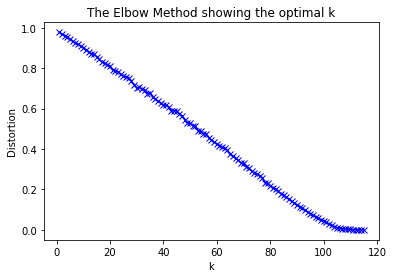

Cluster 0 - 3: crestron op electronics clearance 2019 studio january buildings gpa modeling
Cluster 1 - 11: sql stack fullscreen python django jobtarget fix apis red hat
Cluster 2 - 5: computational genetic gene ux disease biology outstanding prior invitae researchers
Cluster 3 - 3: sales ticket tableau tickets reports ads yankees pricing kore warehouse
Cluster 4 - 10: ca internship transcript wa android students attach protegrity english section
Cluster 5 - 14: contract embedded linux proven python qa perficient os jira automation
Cluster 6 - 4: capital paribus money banking succeeding teamwork consumers bringing respect transformative
Cluster 7 - 6: advertising automation optik tru chef puppet times perl ansible journalism
Cluster 8 - 4: financial risk brokers broker electronic pl ubs hedge trades portfolio
Cluster 9 - 2: equinox consumer js club commission living architecting inspiring brands addition
Cluster 10 - 6: ibm quantum analytics qiskit prof eo immigration hardware sessions

In [338]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
# Using 8 buckets, should use differnt amount.
km = KMeans(n_clusters=20, init='k-means++', max_iter=100, n_init=1)
km.fit(X_tf)

# k means determine k
import time
# 100-150 -> .70-.58
distortions = []
K = range(1, X_tf.shape[0])
for k in K:
    start = time.time()
    X_tf_arr = X_tf.toarray()
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    kmeanModel.fit(X_tf_arr)
    distortions.append(sum(np.min(cdist(X_tf_arr, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_tf_arr.shape[0])
    end = time.time()
    print(k, end - start)
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = feature_names
for i in range(len(order_centroids)):
    print(f"Cluster {i} - {np.where(km.labels_ == i)[0].shape[0]}:" , end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

In [341]:
pd.set_option('display.max_colwidth', -1)

filtered_data = data.loc[ cluster_index(km.labels_, 19), ['company', 'job_title', 'url', 'location']]
# filtered_data = filtered_data[filtered_data['location'].str.contains('New|CT')]
# filtered_data.to_csv('data_engineering.csv', sep=',', encoding='utf-8')
filtered_data

# for i in range(len(order_centroids)):
#     filtered_data = data.loc[ cluster_index(km.labels_, i), ['company', 'job_title', 'url', 'location']]
#     filtered_data['company'] = filtered_data['company'].str.strip()
#     filtered_data.to_csv(f'{filename}/cluster_{i}_k_20.csv', sep=',', encoding='utf-8', index=False)



,company,job_title,url,location
8,BrightStart Institute - Building Skills for the Fu...,Intern / Trainee WEB developer- Full-Stack,https://www.indeed.com/viewjob?jk=e274cc84163ef929,New+York%2C+NY
46,Accenture,Emerging Technology - Software Innovation Specialist,https://www.indeed.com/viewjob?jk=0163a18d48984c7f,New+York%2C+NY
56,Hudson River Trading,Algo Software Engineer (C++/Python),https://www.indeed.com/viewjob?jk=c7c193ae35f5bad7,New+York%2C+NY
59,Hudson River Trading,Algo Software Engineer (C++/Python),https://www.indeed.com/viewjob?jk=c7c193ae35f5bad7,New+York%2C+NY
61,RedRoute,Full Stack Software Engineer,https://www.indeed.com/viewjob?jk=bfd5c9e9aa6b6104,New+York%2C+NY
62,Integrated Management Solutions USA LLC,KDB+/Q Software Engineer,https://www.indeed.com/viewjob?jk=a11d81467860fb69,New+York%2C+NY
76,Condor Alpha Asset Management,Software Developer,https://www.indeed.com/viewjob?jk=a757b3b6b9677244,Greenwich%2C+CT
105,Eastridge Workforce Solutions,Senior Software Engineer,https://www.indeed.com/viewjob?jk=88e08bde12d89549,Greenwich%2C+CT
107,Excellence Community Schools,Computer Science Teacher (CT),https://www.indeed.com/viewjob?jk=ed91b36897edbc0c,Greenwich%2C+CT
110,"BestEx Research Group,LLC",Front End Web Engineer/Full Stack Developer,https://www.indeed.com/viewjob?jk=4a88be57a780cf2e,Greenwich%2C+CT


Next Steps are to sort these words into categories (job, technologies, companies)